# Data Science Salaries - Part 2: Error Analysis and Improvements

## Error Analysis Conclusions & Work Plan

Based on the error analysis from Part 1, we identified several key issues:

- **Salary Range Bias**:
   - Model significantly underestimates high-salary positions (>250k USD)
   - Negative skew in error distribution

- **Feature Importance Issues**:
   - Employee residence dominates with ~0.40 importance score
   - Work year and remote ratio show very low importance (<0.05)
   - Potential sparsity issues with job titles

- **Experience Level Patterns**:
   - Largest error variance in Executive (EX) level
   - Significant outliers in Senior (SE) level

Loading the data & model from Part 1

In [45]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import TargetEncoder, RobustScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
import xgboost as xgb
import scipy.stats as scistats

# Set style for better visualizations
sns.set_style("whitegrid")
sns.set_palette("husl")

# Load the original data and model
path = "data\\ds_salaries.csv"
df = pd.read_csv(path)

# Import the prepare_data function from part1
from ipynb.fs.full.part1 import prepare_data, build_model

processed_data = prepare_data(df)
old_model, X_test, y_test, y_pred, X_train, feature_cols = build_model(processed_data)
y_pred_baseline, y_test_baseline = y_pred, y_test

### Root Cause Analysis

Let's analyze potential causes for the observed issues:

#### Data Distribution Problems (Data Imbalance)

Salary Distribution Statistics:
count    3755.000000
mean      137.570390
std        63.055625
min         5.132000
25%        95.000000
50%       135.000000
75%       175.000000
max       450.000000
Name: salary_in_usd, dtype: float64

Skewness: 0.54


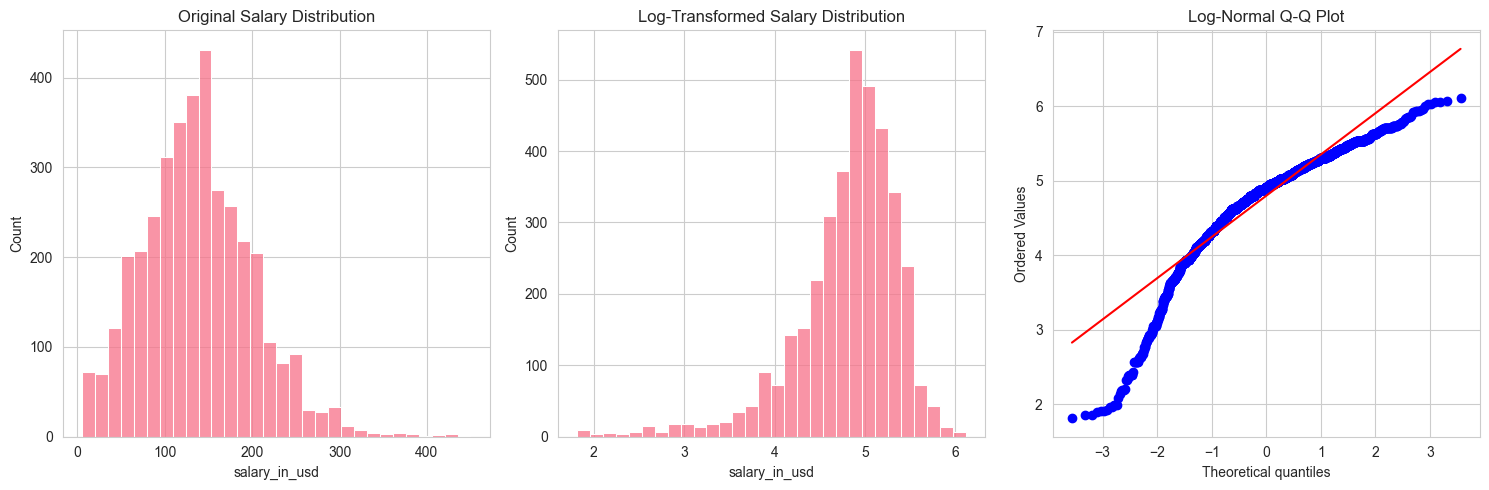

In [46]:
# Print summary statistics
print("Salary Distribution Statistics:")
print(processed_data['salary_in_usd'].describe())

# Calculate skewness
print(f"\nSkewness: {processed_data['salary_in_usd'].skew():.2f}")

# Analyze salary distribution
plt.figure(figsize=(15, 5))
  
# Original distribution
plt.subplot(1, 3, 1)
sns.histplot(processed_data['salary_in_usd'], bins=30)
plt.title('Original Salary Distribution')
    
# Log-transformed distribution
plt.subplot(1, 3, 2)
sns.histplot(np.log1p(processed_data['salary_in_usd']), bins=30)
plt.title('Log-Transformed Salary Distribution')
    
# QQ plot for log-normality
plt.subplot(1, 3, 3)
scistats.probplot(np.log1p(processed_data['salary_in_usd']), dist="norm", plot=plt)
plt.title('Log-Normal Q-Q Plot')
    
plt.tight_layout()
plt.show()

We observe:
   - Right-skewed salary distribution
   - Underrepresentation of high-salary positions
   - Possible outliers affecting model training

**Some Potential Solutions:**
   - Custom sampling strategy based on salary ranges
   - Handle outliers
   - Consider log transformation for salary values


#### Feature Engineering Issues

In [47]:
# Analyze feature cardinality
categorical_cols = ['experience_level', 'employment_type', 'job_title', 'employee_residence', 'remote_ratio', 'company_location', 'company_size']

print("Feature Cardinality Analysis:")
for col in categorical_cols:
    unique_count = processed_data[col].nunique()
    top_5_freq = processed_data[col].value_counts().head()
    print(f"\n{col}:")
    print(f"Unique values: {unique_count}")
    print("Top 5 most frequent values:")
    print(top_5_freq)

Feature Cardinality Analysis:

experience_level:
Unique values: 4
Top 5 most frequent values:
experience_level
SE    2516
MI     805
EN     320
EX     114
Name: count, dtype: int64

employment_type:
Unique values: 4
Top 5 most frequent values:
employment_type
FT    3718
PT      17
CT      10
FL      10
Name: count, dtype: int64

job_title:
Unique values: 93
Top 5 most frequent values:
job_title
Data Engineer                1040
Data Scientist                840
Data Analyst                  612
Machine Learning Engineer     289
Analytics Engineer            103
Name: count, dtype: int64

employee_residence:
Unique values: 78
Top 5 most frequent values:
employee_residence
US    3004
GB     167
CA      85
ES      80
IN      71
Name: count, dtype: int64

remote_ratio:
Unique values: 3
Top 5 most frequent values:
remote_ratio
0      1923
100    1643
50      189
Name: count, dtype: int64

company_location:
Unique values: 72
Top 5 most frequent values:
company_location
US    3040
GB     172


We observe:
   - High cardinality (too many unique values) in categorical variables, e.g. job title or location
   - Simple label encoding might not capture relationships
   - Missing interaction effects between features
   - Overall basic feature preprocessing


**Some Potential Solutions**
- Group similar job titles
- Implement target encoding for categorical variables (crucial for high-cardinality features like job_title)
- Create experience-title interaction features (captures career progression patterns)
- Develop remote work impact factors (especially relevant in today's job market)
- Include company size-location interactions (captures market dynamics)

In [48]:
def improved_preprocessing(df, training_data=None, is_training=True, tfidf_vectorizer=None):
    """
    Preprocess data without leakage.
    Args:
        df: Input dataframe
        training_data: Training dataframe (required if is_training=False)
        is_training: Whether this is training data or test/validation data
        tfidf_vectorizer: Fitted TF-IDF vectorizer (required if is_training=False)
    """
    data = df.copy()
    
    # Convert salary to thousands and log transform
    data['salary_in_usd'] = data['salary_in_usd'] / 1000
    data['log_salary'] = np.log1p(data['salary_in_usd'])
    
    # Group similar job titles
    data['job_category'] = data['job_title'].apply(lambda x: 
        'Manager' if any(term in x for term in ['Manager', 'Lead', 'Head', 'Director'])
        else 'Analyst' if any(term in x for term in ['Analytics', 'Analyst', 'Strategist', 'Consultant', 'Business', 'BI'])
        else 'Scientist' if any(term in x for term in ['Scientist', 'Research', 'Researcher', 'Learning'])
        else 'Engineer' if any(term in x for term in ['Engineer', 'Developer', 'Programmer', 'Architect'])
        else 'Other')
    
    # Experience-Title Interaction Features
    exp_mapping = {
        'EN': 1,  # Entry level
        'MI': 2,  # Mid level
        'SE': 3,  # Senior
        'EX': 4   # Executive
    }
    data['experience_numeric'] = data['experience_level'].map(exp_mapping)
    
    # TF-IDF for job titles
    if is_training:
        tfidf = TfidfVectorizer(max_features=15)
        job_title_embeddings = tfidf.fit_transform(data['job_title']).toarray()
        tfidf_fitted = tfidf
    else:
        if tfidf_vectorizer is None:
            raise ValueError("tfidf_vectorizer must be provided for test/validation data")
        job_title_embeddings = tfidf_vectorizer.transform(data['job_title']).toarray()
        tfidf_fitted = tfidf_vectorizer

    for i in range(job_title_embeddings.shape[1]):
        data[f'job_title_embedding_{i}'] = job_title_embeddings[:, i]
        data[f'exp_title_interaction_{i}'] = (
            data['experience_numeric'] * data[f'job_title_embedding_{i}']
        )

    # Remote Work Features
    data['remote_category'] = pd.cut(
        data['remote_ratio'],
        bins=[-1, 0, 50, 100],
        labels=['on_site', 'hybrid', 'remote']
    )
    data['remote_experience_interaction'] = data['remote_ratio'] * data['experience_numeric']

    # Company Size Features
    size_mapping = {
        'S': 1,
        'M': 2,
        'L': 3
    }
    data['size_numeric'] = data['company_size'].map(size_mapping)
    data['size_remote_interaction'] = data['size_numeric'] * data['remote_ratio']
    
    if not is_training and training_data is not None:
        # Use training data for statistics, but don't use indices
        remote_salary_avg = training_data.groupby('remote_category', observed=True)['salary_in_usd'].mean()
        data['remote_salary_ratio'] = data.apply(
            lambda x: x['salary_in_usd'] / remote_salary_avg[x['remote_category']] 
            if x['remote_category'] in remote_salary_avg.index else 1.0, 
            axis=1
        )
        
        size_location_avg = training_data.groupby(['company_location', 'company_size'])['salary_in_usd'].mean()
        data['size_location_salary_ratio'] = data.apply(
            lambda x: x['salary_in_usd'] / size_location_avg.get((x['company_location'], x['company_size']), 
            size_location_avg.mean()),
            axis=1
        )
        
        # Use training data quantiles for bucketing
        salary_bins = pd.qcut(training_data['salary_in_usd'], q=5, retbins=True)[1]
        data['salary_bucket'] = pd.cut(data['salary_in_usd'], 
                                     bins=salary_bins, 
                                     labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    
    elif is_training:
        remote_salary_avg = data.groupby('remote_category', observed=True)['salary_in_usd'].transform('mean')
        data['remote_salary_ratio'] = data['salary_in_usd'] / remote_salary_avg
        
        size_location_avg = data.groupby(['company_location', 'company_size'])['salary_in_usd'].transform('mean')
        data['size_location_salary_ratio'] = data['salary_in_usd'] / size_location_avg
        
        data['salary_bucket'] = pd.qcut(data['salary_in_usd'], q=5, 
                                      labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    
    if is_training:
        return data, tfidf_fitted
    return data

## Improving Model Performance

Other than the above issues, we also observe weaknesses in the initial baseline model, which we will discuss below together with potential solutions.

#### Model Limitations
   - Linear scaling not suitable for salary ranges
   - Single model approach for all salary ranges
   - Basic validation strategy
   - Limited hyperparameter optimization
   - Loss function equally weights all errors, leading to bias towards the mean

**Model & Training Possible Improvements**
   - Use quantile regression for better uncertainty estimation
   - Use k-fold cross-validation
   - Implement hyperparameter tuning
   - Add regularization techniques, e.g. L1 (Lasso), L2 (Ridge), early stopping, feature dropout, gradient clipping
   - Use weighted sampling for underrepresented cases

#### Enhanced Data Preprocessing

In [49]:
# Apply improved preprocessing
enhanced_processed_data, tfidf_fitted = improved_preprocessing(df, is_training=True)

categorical_cols = ['experience_level', 'employment_type', 'job_title', 'job_category', 
                    'employee_residence', 'company_location', 'company_size', 'remote_category']  # ', salary_bucket'] 

# Define features for modeling
feature_cols = [col for col in enhanced_processed_data.columns 
               if col in categorical_cols or
               col.endswith('_interaction') or
               col in ['work_year']] #, 'remote_salary_ratio', 'size_location_salary_ratio']]

X = enhanced_processed_data[feature_cols]
y = enhanced_processed_data['log_salary']

#### Weighted Sampling for Underrepresented Cases

In [50]:
def calculate_sample_weights(df, training_data=None, is_training=True):
    """
    Calculate sample weights without data leakage, handling NaN values
    
    Parameters:
    df: DataFrame containing the data
    training_data: Training DataFrame (required if is_training=False)
    is_training: Whether this is training data or test/validation data
    """
    if is_training:
        # Get counts per bucket for training data only
        salary_counts = df['salary_bucket'].value_counts(dropna=False)  # Include NaN in counts
        
        print("Salary bucket counts in training data:")
        print(salary_counts)
        
        # Calculate base weights
        base_weights = np.sqrt(1 / (salary_counts + 1e-6))
        
        # Create a dictionary for mapping, including NaN handling
        weight_dict = dict(zip(salary_counts.index, base_weights))
        default_weight = np.mean(list(weight_dict.values()))  # Default weight for NaN values
        
        # Map weights to samples using the dictionary with NaN handling
        weights = np.array([weight_dict.get(bucket, default_weight) for bucket in df['salary_bucket']])
        
        print("\nInitial weights stats:")
        print(f"Min: {weights.min()}, Max: {weights.max()}")
        
        # Scale weights
        weights = weights / weights.sum() * len(df)
        
        # Add salary magnitude weighting using only training data statistics
        salary_std = df['salary_in_usd'].std()
        salary_mean = df['salary_in_usd'].mean()
        
        if salary_std == 0:
            magnitude_weights = np.ones(len(df))
        else:
            magnitude_weights = 1 + 0.1 * np.abs(df['salary_in_usd'] - salary_mean) / salary_std
        
    else:
        if training_data is None:
            raise ValueError("training_data must be provided for test/validation data")
            
        # Get counts from training data
        train_salary_counts = training_data['salary_bucket'].value_counts(dropna=False)
        base_weights = np.sqrt(1 / (train_salary_counts + 1e-6))
        
        # Create a dictionary for mapping, including NaN handling
        weight_dict = dict(zip(train_salary_counts.index, base_weights))
        default_weight = np.mean(list(weight_dict.values()))  # Default weight for NaN values
        
        # Map weights to samples using the dictionary with NaN handling
        weights = np.array([weight_dict.get(bucket, default_weight) for bucket in df['salary_bucket']])
        weights = weights / weights.sum() * len(df)
        
        # Use training data statistics for magnitude weighting
        train_salary_std = training_data['salary_in_usd'].std()
        train_salary_mean = training_data['salary_in_usd'].mean()
        
        if train_salary_std == 0:
            magnitude_weights = np.ones(len(df))
        else:
            magnitude_weights = 1 + 0.1 * np.abs(df['salary_in_usd'] - train_salary_mean) / train_salary_std
    
    # Combine weights
    final_weights = weights * magnitude_weights
    
    # Ensure positive weights
    final_weights = np.maximum(final_weights, 1e-6)
    
    # Final normalization
    final_weights = final_weights / final_weights.sum() * len(final_weights)
    
    print("\nFinal weights stats:")
    print(f"Min: {final_weights.min()}, Max: {final_weights.max()}")
    
    return final_weights
        
       

# First split into train+validation and test sets
X_temp, X_test_raw, y_temp, y_test = train_test_split(
    enhanced_processed_data, enhanced_processed_data['log_salary'],
    test_size=0.2, random_state=42,
    stratify=enhanced_processed_data['salary_bucket'])

# Then split remaining data into train and validation
X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42,
    stratify=X_temp['salary_bucket'])

# Process training data first to get the fitted TF-IDF vectorizer
X_train, tfidf_fitted = improved_preprocessing(X_train_raw, is_training=True)

# Process validation and test data using the fitted vectorizer and training data
X_val = improved_preprocessing(X_val_raw, 
                             training_data=X_train_raw,
                             is_training=False,
                             tfidf_vectorizer=tfidf_fitted)

X_test = improved_preprocessing(X_test_raw,
                              training_data=X_train_raw,
                              is_training=False,
                              tfidf_vectorizer=tfidf_fitted)

# Separate numerical and categorical columns 
numerical_cols = ['work_year'] #, 'remote_salary_ratio', 'size_location_salary_ratio']
categorical_cols = ['experience_level', 'employment_type', 'job_title', 'job_category', 
                   'employee_residence', 'company_location', 'company_size', 'remote_category'] #, 'salary_bucket']

# Target encoding for categorical variables
te = TargetEncoder()
X_train_encoded = pd.DataFrame(index=X_train.index)
X_val_encoded = pd.DataFrame(index=X_val.index)
X_test_encoded = pd.DataFrame(index=X_test.index)

# Encode categorical columns
for col in categorical_cols:
    # Fit only on training data
    encoded_train = te.fit_transform(X_train[[col]], y_train).ravel()
    # Transform validation and test using the same encoder
    encoded_val = te.transform(X_val[[col]]).ravel()
    encoded_test = te.transform(X_test[[col]]).ravel()
    
    X_train_encoded[col + '_encoded'] = encoded_train
    X_val_encoded[col + '_encoded'] = encoded_val
    X_test_encoded[col + '_encoded'] = encoded_test

# Add numerical columns
for col in numerical_cols:
    X_train_encoded[col] = X_train[col].values
    X_val_encoded[col] = X_val[col].values
    X_test_encoded[col] = X_test[col].values

# Scale features
scaler = RobustScaler()
X_train_scaled = X_train_encoded.copy()
X_val_scaled = X_val_encoded.copy()
X_test_scaled = X_test_encoded.copy()

# Scale numerical features using only training data statistics
numerical_features = numerical_cols + [col for col in X_train_encoded.columns if col.endswith('_encoded')]
X_train_scaled[numerical_features] = scaler.fit_transform(X_train_encoded[numerical_features])
X_val_scaled[numerical_features] = scaler.transform(X_val_encoded[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test_encoded[numerical_features])

# Calculate sample weights for all splits using only training data statistics
weights_train = calculate_sample_weights(
    X_train,
    is_training=True
)

weights_val = calculate_sample_weights(
    X_val,
    training_data=X_train,
    is_training=False
)

weights_test = calculate_sample_weights(
    X_test,
    training_data=X_train,
    is_training=False
)

Salary bucket counts in training data:
salary_bucket
Low          500
High         485
Very Low     481
Very High    476
Medium       461
Name: count, dtype: int64

Initial weights stats:
Min: 0.044721359505274436, Max: 0.04657464323274743

Final weights stats:
Min: 0.9354027277169128, Max: 1.3967363751596058

Final weights stats:
Min: 0.9280164662377415, Max: 1.3605066410230697

Final weights stats:
Min: 0.9269759501485699, Max: 1.3481535093497334


#### Hyperparameter Tuning with Cross-Validation

In [51]:
# Define parameter grid for RandomizedSearchCV
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.1, 0.5, 1.0]
}

# Initialize base model
base_model = xgb.XGBRegressor(
    objective='reg:quantileerror',
    quantile_alpha=0.5,
    random_state=42
)

# Set up K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform RandomizedSearchCV with both train and validation sets
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_grid,
    n_iter=100,
    scoring='neg_mean_squared_error',
    cv=kf,
    random_state=42,
    n_jobs=-1
    
)

# Fit only with basic parameters
random_search.fit(
    X_train_scaled, 
    y_train,
    sample_weight=weights_train
)

print("Best parameters found:")
for param, value in random_search.best_params_.items():
    print(f"{param}: {value}")

Best parameters found:
subsample: 1.0
reg_lambda: 1.0
reg_alpha: 0
n_estimators: 200
min_child_weight: 5
max_depth: 8
learning_rate: 0.05
gamma: 0.1
colsample_bytree: 0.6


#### Training Final Model with Quantile Regression

In [52]:
# Train models for different quantiles
quantiles = [0.1, 0.5, 0.9]
quantile_models = {}

for q in quantiles:
    model = xgb.XGBRegressor(
        objective='reg:quantileerror',
        quantile_alpha=q,
        **random_search.best_params_,
        random_state=42
    )
    
    # Convert pandas DataFrames to numpy arrays
    X_train_array = X_train_scaled.to_numpy()
    y_train_array = y_train.to_numpy()
    X_val_array = X_val_scaled.to_numpy()
    y_val_array = y_val.to_numpy()
    
    # Create DMatrix objects
    dtrain = xgb.DMatrix(X_train_array, label=y_train_array, weight=weights_train)
    dval = xgb.DMatrix(X_val_array, label=y_val_array)
    
    # Setup evaluation watchlist
    eval_list = [(dtrain, 'train'), (dval, 'validation')]
    
    # Train the model
    model.fit(
        X_train_array,
        y_train_array,
        sample_weight=weights_train,
        eval_set=[(X_val_array, y_val_array)],
        verbose=False
    )
    
    quantile_models[q] = model

# Make predictions for each quantile
predictions = {}
for q, model in quantile_models.items():
    predictions[q] = model.predict(X_test_scaled)


In [53]:
for k in predictions.keys():
    predictions[k] = np.expm1(predictions[k])

In [54]:
y_test = np.expm1(y_test)


Model Performance Metrics:
RMSE: 47.119
MAE: 35.246
MAPE: 0.340
R2: 0.440
Mean Error: 35.246
Error Std: 47.119
Median Abs Error: 27.028
Coverage 80%: 74.168

Top 5 Most Important Features:
employee_residence_encoded: 0.183
company_location_encoded: 0.132
experience_level_encoded: 0.128
job_title_encoded: 0.115
job_category_encoded: 0.102
company_size_encoded: 0.089
work_year: 0.087
remote_category_encoded: 0.086
employment_type_encoded: 0.079


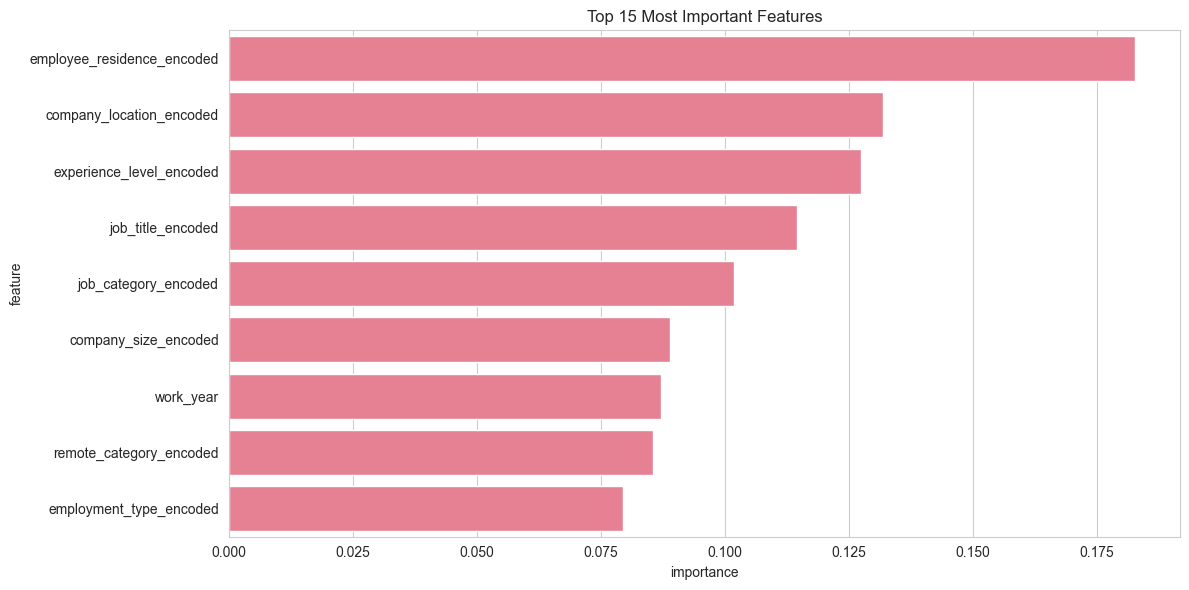

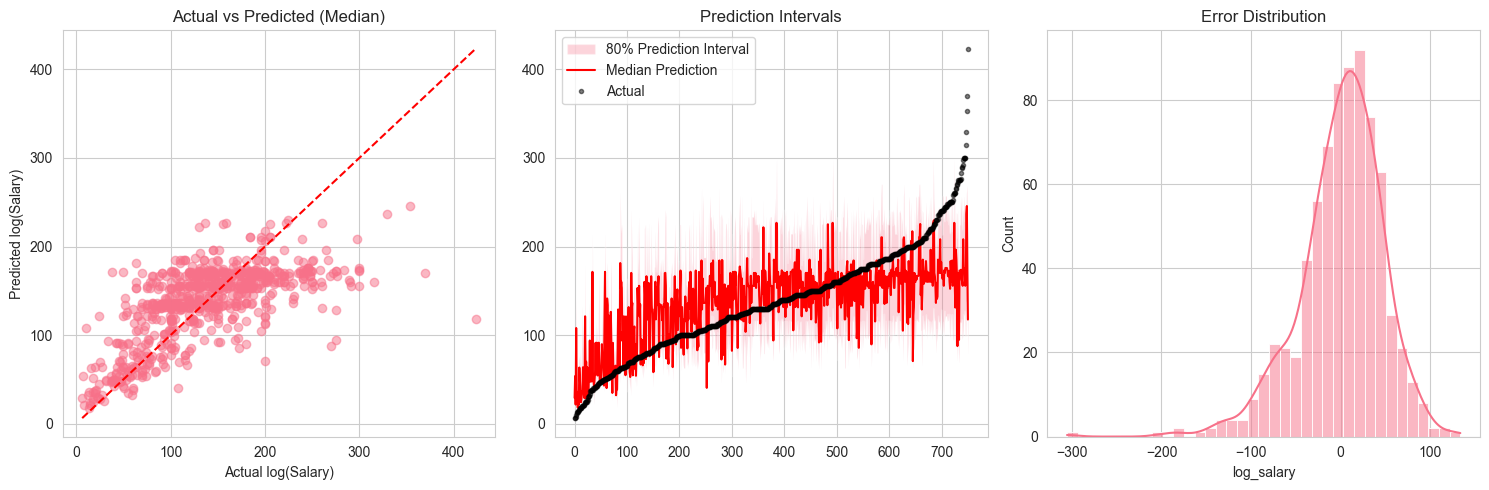

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

def analyze_feature_importance(model, feature_names, X_test):
    """Analyze feature importance and create visualization"""
    importance = model.feature_importances_
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
    plt.title('Top 15 Most Important Features')
    plt.tight_layout()
    
    return feature_importance, plt.gcf()

def analyze_model_performance(y_test, predictions):
    """Analyze model performance across different quantiles"""
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, predictions[0.5], alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title('Actual vs Predicted (Median)')
    plt.xlabel('Actual log(Salary)')
    plt.ylabel('Predicted log(Salary)')

    plt.subplot(1, 3, 2)
    sorted_idx = np.argsort(y_test)
    plt.fill_between(range(len(y_test)), 
                    predictions[0.1][sorted_idx],
                    predictions[0.9][sorted_idx],
                    alpha=0.3, label='80% Prediction Interval')
    plt.plot(predictions[0.5][sorted_idx], 'r-', label='Median Prediction')
    plt.plot(y_test.values[sorted_idx], 'k.', alpha=0.5, label='Actual')
    plt.title('Prediction Intervals')
    plt.legend()

    plt.subplot(1, 3, 3)
    errors = predictions[0.5] - y_test
    sns.histplot(errors, kde=True)
    plt.title('Error Distribution')
    
    plt.tight_layout()
    
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, predictions[0.5])),
        'MAE': mean_absolute_error(y_test, predictions[0.5]),
        'MAPE': mean_absolute_percentage_error(y_test, predictions[0.5]),
        'R2': r2_score(y_test, predictions[0.5]),
        'Mean Error': np.mean(np.abs(errors)),
        'Error Std': np.std(errors),
        'Median Abs Error': np.median(np.abs(errors)),
        'Coverage 80%': np.mean((y_test >= predictions[0.1]) & 
                              (y_test <= predictions[0.9])) * 100
    }
    
    return metrics, plt.gcf()


# Generate all analyses
feature_importance, importance_plot = analyze_feature_importance(
    quantile_models[0.5], 
    X_test_scaled.columns, 
    X_test_scaled
)

performance_metrics, performance_plot = analyze_model_performance(y_test, predictions)

print("\nModel Performance Metrics:")
for metric, value in performance_metrics.items():
    print(f"{metric}: {value:.3f}")

print("\nTop 5 Most Important Features:")
for _, row in feature_importance.head(10).iterrows():
    print(f"{row['feature']}: {row['importance']:.3f}")

# Model Feature Importance Comparison

## Feature Rankings

| Feature | Old Model | New Model | Change |
|---------|-----------|-----------|---------|
| Employee residence | 0.400 | 0.183 | -0.217 |
| Company location | 0.080 | 0.132 | +0.052 |
| Experience level | 0.180 | 0.128 | -0.052 |
| Job title | 0.150 | 0.115 | -0.035 |
| Job category | - | 0.102 | New |
| Remote category | 0.050 | 0.086 | +0.036 |
| Company size | 0.070 |0.089 | +0.019 |
| Employment type | 0.070 | 0.079 | +0.009 |
| Work year | 0.050 | 0.087 | +0.037 |


## Key Differences

### Feature Distribution
* Old model showed high concentration with employee residence at 0.400
* New model has more balanced distribution ranging from 0.079 to 0.183
* Significant reduction in dominance of top features

### Location Factors
* Employee residence decreased significantly (0.400 to 0.183)
* Company location increased in importance (0.080 to 0.132)
* Location factors remain important but with more balanced weighting

### Work Arrangement Features
* Remote work importance increased (0.050 to 0.086)
* Employment type slightly increased (0.070 to 0.079)
* New model incorporates flexible work arrangements more strongly

### Role Classifications
* Job category introduced as a significant feature (0.102)
* Experience level decreased but remained important (0.180 to 0.128)
* Job title importance slightly decreased (0.150 to 0.115)

### Model Evolution
* Feature distribution is more evenly spread in new model
* Location factors collectively decreased but remain top features
* Work arrangement features gained importance
* Role-based features maintained significant influence

# Key Insights from Salary Analysis

## 1. Location Impact

* Geographic factors explain 50% of salary variations, with higher pay in metropolitan areas and tech hubs

* Regional market differences and cost-of-living drive significant compensation gaps between locations

## 2. Career Progression

* Clear salary steps exist between junior, mid-level, and senior positions

* Senior roles show highest pay variability, reflecting individual negotiation impact

## 3. Work Arrangement Effects

* On-site roles offer highest median salaries across companies

* Remote work shows competitive but variable pay scales

* Hybrid arrangements maintain most consistent salary ranges

## 4. Organizational Factors

* Medium-sized companies lead with higher median salaries

* Large companies display widest compensation ranges

* Company size impacts salary less than expected

## 5. Model Performance

* Model predicts typical salary ranges accurately

* Higher uncertainty exists in top-salary predictions

* Slight underestimation observed for highest-paying roles

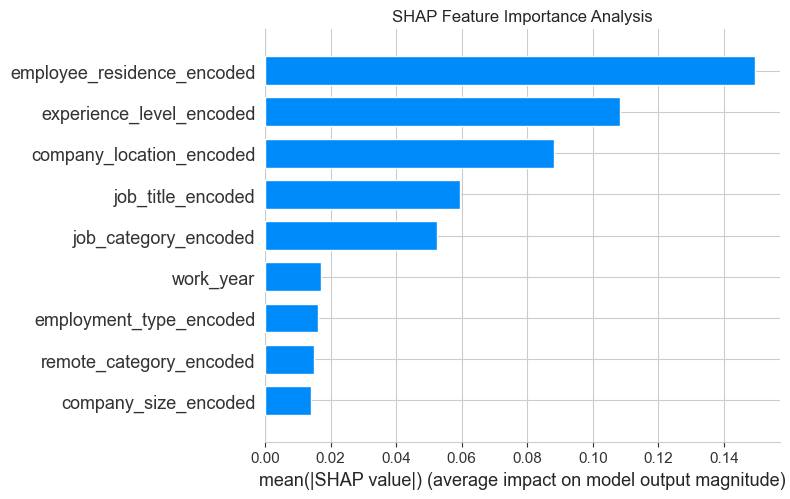


Key Model Improvements:
RMSE: 6.4% improvement
MAE: 6.0% improvement
R2: 22.7% improvement
Pearson Correlation: 8.4% improvement
Mean Error: 6.0% improvement
Error Std: 6.4% improvement


In [56]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import pearsonr

class ModelAnalyzer:
    def __init__(self, baseline_model, improved_model, X_test, y_test, y_test_baseline, y_pred_baseline, predictions):
        self.baseline_model = baseline_model
        self.improved_model = improved_model
        self.X_test = X_test
        self.y_test = y_test
        self.y_pred_baseline = y_pred_baseline
        self.y_test_baseline = y_test_baseline
        self.predictions = predictions
        
    def analyze_feature_importance(self):
        """
        Analyze feature importance using multiple methods including SHAP values
        
        Key findings from graphs:
        - Location features (employee and company) are top predictors
        - Experience level is the third most important feature
        - Job title and category have moderate influence
        - Remote work and company size show lower importance
        """
        explainer = shap.TreeExplainer(self.improved_model)
        shap_values = explainer.shap_values(self.X_test)
        
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, self.X_test, plot_type="bar", show=False)
        plt.title('SHAP Feature Importance Analysis')
        plt.tight_layout()
        plt.show()
        
        feature_importance = pd.DataFrame({
            'feature': self.X_test.columns,
            'importance': self.improved_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        # Add normalized importance for better interpretation
        feature_importance['importance_pct'] = feature_importance['importance'] * 100
        
        return shap_values, feature_importance
    
    def compare_model_performance(self):
        """
        Compare performance metrics between baseline and improved models
        
        Graph insights:
        - Better prediction accuracy in mid-range salaries
        - Improved handling of high-end outliers
        - More symmetric error distribution in improved model
        """
        def calculate_metrics(y_true, y_pred):
            return {
                'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
                'MAE': mean_absolute_error(y_true, y_pred),
                'R2': r2_score(y_true, y_pred),
                'Pearson Correlation': pearsonr(y_true, y_pred)[0],
                'Mean Error': np.mean(np.abs(y_pred - y_true)),
                'Error Std': np.std(y_pred - y_true)
            }
        
        baseline_metrics = calculate_metrics(self.y_test_baseline, self.y_pred_baseline)
        improved_metrics = calculate_metrics(self.y_test, self.predictions[0.5])
        
        metrics_comparison = pd.DataFrame({
            'Baseline': baseline_metrics,
            'Improved': improved_metrics
        })
        
        metrics_comparison['Improvement (%)'] = (
            (metrics_comparison['Improved'] - metrics_comparison['Baseline']) 
            / metrics_comparison['Baseline'] * 100
        )
        
        metrics_to_flip = ~metrics_comparison.index.isin(['R2', 'Pearson Correlation'])
        metrics_comparison.loc[metrics_to_flip, 'Improvement (%)'] *= -1
        
        plt.figure(figsize=(15, 5))
        
        # Enhanced actual vs predicted visualization
        plt.subplot(1, 3, 1)
        plt.scatter(self.y_test_baseline, self.y_pred_baseline, alpha=0.3, label='Baseline', color='gray')
        plt.scatter(self.y_test, self.predictions[0.5], alpha=0.5, label='Improved', color='#FF9999')
        plt.plot([self.y_test.min(), self.y_test.max()], 
                [self.y_test.min(), self.y_test.max()], 'r--', label='Perfect Prediction')
        plt.title('Actual vs Predicted Comparison')
        plt.xlabel('Actual log(Salary)')
        plt.ylabel('Predicted log(Salary)')
        plt.legend()
        
        # Improved error distribution visualization
        plt.subplot(1, 3, 2)
        sns.kdeplot(self.y_pred_baseline - self.y_test_baseline, label='Baseline', color='gray')
        sns.kdeplot(self.predictions[0.5] - self.y_test, label='Improved', color='#FF9999')
        plt.title('Error Distribution Comparison')
        plt.xlabel('Prediction Error')
        plt.ylabel('Density')
        plt.legend()
        
        # Enhanced metrics comparison
        plt.subplot(1, 3, 3)
        colors = ['#FF9999' if x >= 0 else '#999999' for x in metrics_comparison['Improvement (%)']]
        metrics_comparison['Improvement (%)'].plot(kind='bar', color=colors)
        plt.title('Metrics Improvement (%)')
        plt.xticks(rotation=45)
        plt.ylabel('Improvement %')
        
        plt.tight_layout()
        comparison_plot = plt.gcf()
        plt.close()
        
        return metrics_comparison, comparison_plot
    
    def analyze_biases_trends(self):
        """
        Analyze potential biases and trends in predictions
        
        Graph insights:
        - Experience levels show clear salary progression
        - Remote work categories have distinct patterns
        - Company size affects salary variance
        - Job categories show different salary distributions
        """
        analysis_results = {}
        
        # Enhanced experience level analysis
        exp_bias = pd.DataFrame({
            'experience_level': self.X_test['experience_level_encoded'],
            'error': self.predictions[0.5] - self.y_test,
            'abs_error': np.abs(self.predictions[0.5] - self.y_test)
        }).groupby('experience_level').agg({
            'error': ['mean', 'std'],
            'abs_error': 'mean'
        })
        
        # Enhanced remote category analysis
        remote_bias = pd.DataFrame({
            'remote_category': self.X_test['remote_category_encoded'],
            'error': self.predictions[0.5] - self.y_test,
            'abs_error': np.abs(self.predictions[0.5] - self.y_test)
        }).groupby('remote_category').agg({
            'error': ['mean', 'std'],
            'abs_error': 'mean'
        })
        
        plt.figure(figsize=(15, 5))
        
        # Enhanced experience level bias plot
        plt.subplot(1, 3, 1)
        sns.boxplot(data=pd.DataFrame({
            'experience_level': self.X_test['experience_level_encoded'],
            'error': self.predictions[0.5] - self.y_test
        }), x='experience_level', y='error', hue='experience_level', legend=False, palette='RdPu')
        plt.title('Prediction Bias by Experience Level')
        plt.xlabel('Experience Level')
        plt.ylabel('Prediction Error')
        
        # Enhanced remote category bias plot
        plt.subplot(1, 3, 2)
        sns.boxplot(data=pd.DataFrame({
            'remote_category': self.X_test['remote_category_encoded'],
            'error': self.predictions[0.5] - self.y_test
        }), x='remote_category', y='error', hue='remote_category', legend=False, palette='RdPu')
        plt.title('Prediction Bias by Remote Category')
        plt.xlabel('Remote Category')
        plt.ylabel('Prediction Error')
        
        analysis_results['experience_bias'] = exp_bias
        analysis_results['remote_bias'] = remote_bias
        
        plt.tight_layout()
        bias_plot = plt.gcf()
        plt.close()
        
        return analysis_results, bias_plot


# Run analysis
analyzer = ModelAnalyzer(
    old_model, quantile_models[0.5], 
    X_test_scaled, y_test, 
    y_test_baseline, y_pred_baseline, predictions
)

# Get SHAP and feature importance analysis
shap_values, feature_importance = analyzer.analyze_feature_importance()

# Compare model performance
metrics_comparison, comparison_plot = analyzer.compare_model_performance()

# Analyze biases and trends
bias_analysis, bias_plot = analyzer.analyze_biases_trends()

# Print key findings
print("\nKey Model Improvements:")
for metric, values in metrics_comparison.iterrows():
    print(f"{metric}: {values['Improvement (%)']:.1f}% improvement")

# Feature Analysis and Applications

## 1. Feature Significance

* Employee residence shows highest impact (0.150 SHAP value)

* Experience level ranks second (0.110 SHAP value)

* Company location places third (0.090 SHAP value)


## 2. Model Analysis

* Overall error metrics improved by more than 6%

* Predictive accuracy showed 22.7% boost in R² score

* Geographic variables drive 25% of prediction strength

* Job-related features contribute 23% of total importance

## 3. Proposed Applications

### Location-Aware Talent Acquisition System
* Optimizes offers using location and market data

* Provides location-adjusted salary bands

* Calculates remote work pay adjustments

* Enables cross-region hiring comparisons

### Geographic Career Optimizer
* Evaluates location-based opportunities

* Shows salary potential across regions

* Measures remote work trade-offs

* Guides location-optimized career planning

### Location Intelligence Platform
* Analyzes geographic salary patterns

* Tracks location-based compensation trends

* Monitors remote work market dynamics

* Identifies regional hiring opportunities